In [ ]:
import pandas as pd
import numpy as np
import progressbar
import tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import time
import math
import statistics
from google.colab import drive
import pandas as pd
import numpy as np
import math
import statistics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import time
from google.colab import drive

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_path = 'gdrive/My Drive/Summer Research/Simulated CGM Data/Extracted/'
d1namo_data_path = 'gdrive/My Drive/Summer Research/Glucose/Diabetes/Cleaned Data/'

Import data

In [ ]:
def getData(c, fn):
  if c == 'Extracted':
    data_total = 20
    train_size = 15
    t_train = np.array(list(range(512*train_size)))
    t_test = np.array(list(range(512*train_size,512*data_total)))
    y_train = np.zeros(512*train_size)
    y_test = np.zeros(512*(data_total-train_size))

    for i in range(train_size):
      y_train[range(512*i,512*(i+1))] = np.loadtxt(data_path+'adult#001_'+f'{(i+1):03d}'+'.csv', delimiter=',')

    for i in range(train_size,data_total):
      y_test[range(512*(i-train_size),512*(i-train_size+1))] = np.loadtxt(data_path+'adult#001_'+f'{(i+1):03d}'+'.csv', delimiter=',')

    X_train = np.stack((t_train,y_train),axis=1)
    X_test = np.stack((t_test,y_test),axis=1)
  elif c == 'D1NAMO':
    y = np.loadtxt(d1namo_data_path+'glucose ('+str(fn)+').csv', delimiter=',', skiprows=1, usecols=[2])
    length = len(y)
    train_size = int(0.6*length)
    y_train = y[range(train_size)]
    y_test = y[range(train_size,length)]
    t_train = np.array(list(range(train_size)))
    t_test = np.array(list(range(train_size,length)))
    X_train = np.stack((t_train,y_train),axis=1)
    X_test = np.stack((t_test,y_test),axis=1)
  return X_train, X_test

Normalization

In [ ]:
def normalize(X_train, interval_length):
  scaler = MinMaxScaler(feature_range = (0, 1))
  X_train_scaled = scaler.fit_transform(X_train)

  features_set = []
  labels = []
  for i in range(interval_length, len(X_train)):
      features_set.append(X_train_scaled[i-interval_length:i, 1])
      labels.append(X_train_scaled[i, 1])

  features_set, labels = np.array(features_set), np.array(labels)
  features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
  return features_set, labels, scaler

Create and train the LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

def LSTM_Model():
  #Creating the model
  model = Sequential()

  model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50))
  model.add(Dropout(0.2))

  model.add(Dense(units = 1))

  return model

Test the LSTM

In [ ]:
def predict_LSTM(X_test, model, scaler, timestep_to_predict, interval_length):
  X_test_scaled = scaler.fit_transform(X_test)

  test_features = []
  for i in range(interval_length, len(X_test)):
      test_features.append(X_test_scaled[i-interval_length:i, 1])
  test_features = np.array(test_features)
  test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

  p = list()
  predictions = np.zeros((len(test_features)-timestep_to_predict,2))
  predictions[:,0] = X_test_scaled[-len(predictions):,0]

  widgets = [' [',
        progressbar.Timer(format= 'elapsed time: %(elapsed)s'),
        '] ',
          progressbar.Bar('#'),' (',
          progressbar.ETA(), ') ',
          ]
  bar = progressbar.ProgressBar(max_value=len(predictions), widgets=widgets).start()
  count = 0

  for j in range(len(predictions)):
    count += 1
    bar.update(count)
    for i in range(timestep_to_predict):
      inp = test_features[j+i:(j+i+1),:,:]
      if i != 0:
        inp[:,range((interval_length-i),(interval_length)),:] = np.asarray(p).reshape(1,i,1)
      p.append(model.predict(inp)[0,0])
    predictions[j,1] = p[9]
    p.clear()

  predictions = scaler.inverse_transform(predictions)
  return predictions

Performance

In [ ]:
def performance(X_test, predictions, time_in_minutes, fname):
  plt.figure(figsize=(16,9))
  plt.plot(range(0,5*len(predictions),5), 18.016*X_test[-len(predictions):,1], color='blue', label='Actual CGM')
  plt.plot(range(0,5*len(predictions),5), 18.016*predictions[:,1], color='red', label='Predicted CGM')
  plt.title('CGM Prediction ('+str(time_in_minutes)+' minutes ahead)')
  plt.xlabel('Time (minutes)')
  plt.ylabel('CGM (mg/dL)')
  plt.legend()
  rmse = math.sqrt(mean_squared_error(X_test[-len(predictions):,1], predictions[:,1]))
  std = statistics.stdev(X_test[-len(predictions):,1])
  avg_diff = 0
  for i in range(len(predictions)-1):
    avg_diff += float(abs(X_test[-len(predictions)+i+1,1] - predictions[i,1]))
  avg_diff = avg_diff / (len(predictions)-1)

  plt.savefig('gdrive/My Drive/Summer Research/Figures/LSTM/D1NAMO/'+str(time_in_minutes)+' minutes ahead/'+fname)
  return rmse, std, avg_diff

Epoch 1/100
16/16 [==============================] - 16s 651ms/step - loss: 0.0596
Epoch 2/100
16/16 [==============================] - 11s 660ms/step - loss: 0.0239
Epoch 3/100
16/16 [==============================] - 11s 654ms/step - loss: 0.0180
Epoch 4/100
16/16 [==============================] - 11s 654ms/step - loss: 0.0154
Epoch 5/100
16/16 [==============================] - 11s 660ms/step - loss: 0.0138
Epoch 6/100
16/16 [==============================] - 11s 658ms/step - loss: 0.0095
Epoch 7/100
16/16 [==============================] - 11s 655ms/step - loss: 0.0093
Epoch 8/100
16/16 [==============================] - 11s 655ms/step - loss: 0.0097
Epoch 9/100
16/16 [==============================] - 11s 659ms/step - loss: 0.0082
Epoch 10/100
16/16 [==============================] - 11s 660ms/step - loss: 0.0079
Epoch 11/100
16/16 [==============================] - 11s 661ms/step - loss: 0.0079
Epoch 12/100
16/16 [==============================] - 11s 657ms/step - loss: 0.0077
E

 [elapsed time: 0:07:43] |##################################| (ETA:  00:00:00) 

TypeError: ignored

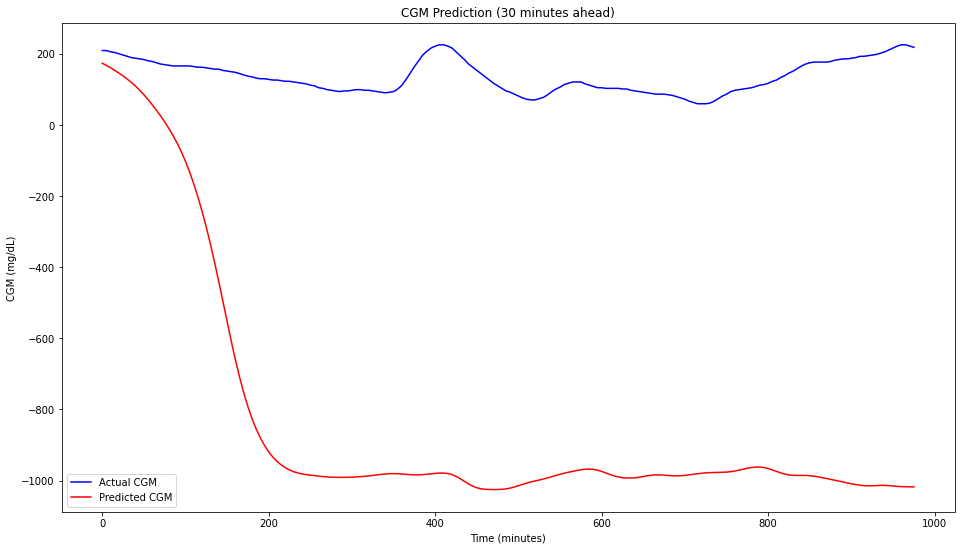

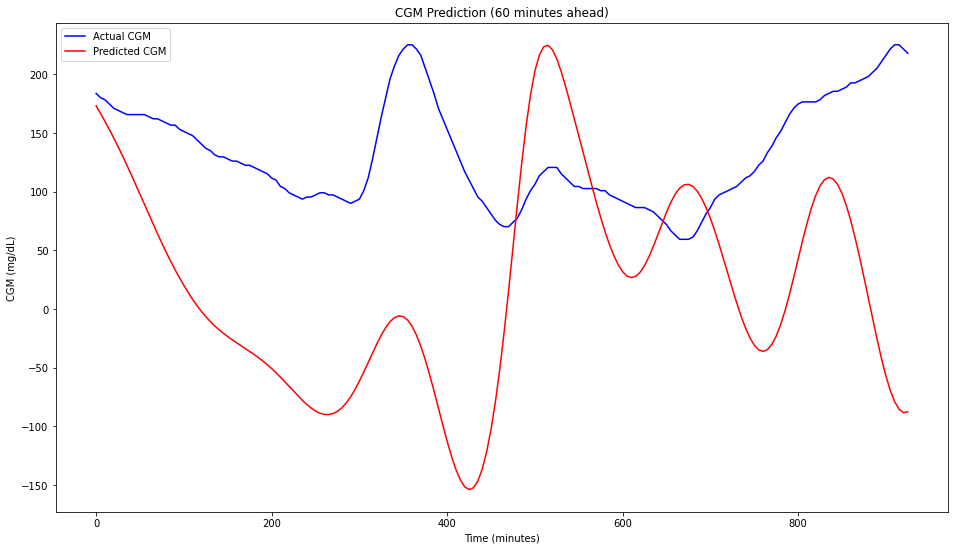

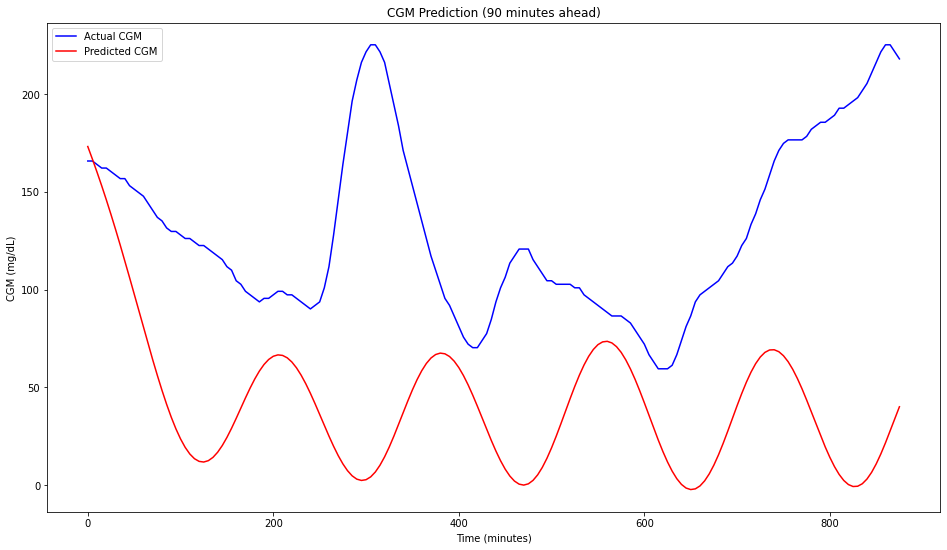

In [ ]:
for fn in [1,2,4,5,6,7,8]:
  interval_length = 180
  X_train, X_test = getData('D1NAMO', fn)
  features_set, labels, scaler = normalize(X_train, interval_length)
  model = LSTM_Model()
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  model.fit(features_set, labels, epochs = 100, batch_size = 32)

  rmses = []
  stds = []
  maes = []
  for i in [10,20,30]:
    predictions = predict_LSTM(X_test, model, scaler, timestep_to_predict=i, interval_length=interval_length)
    rmse, std, mae = performance(X_test, predictions, time_in_minutes=3*i, fname=str(fn)+' no wt.png')
    rmses.append(rmse)
    stds.append(std)
    maes.append(mae)
  stats = {'RMSE':18.016*rmses, 'Standard Deviation':18.016*stds, 'MAE':18.016*maes}
  df = pd.DataFrame(stats)
  df.index = ['30 min', '60 min', '90 min']
  df.to_csv('gdrive/My Drive/Summer Research/Figures/LSTM/D1NAMO/'+str(fn)+'.csv')